In [3]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
import numpy as np

In [4]:
# 58p
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [7]:
def sampling(args: tuple):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0, stddev=epsilon_std)
    
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [8]:
# 인코더 만들기
x = Input(shape=(original_dim), name="input") # 인코더 입력
h = Dense(intermediate_dim, activation="relu", name="encoding")(x) # 중간층
z_mean = Dense(latent_dim, name="mean")(h) # 잠재 공간의 평균을 정의합니다.
z_log_var = Dense(latent_dim, name="log-variance")(h) # 잠재 공간의 로그 분산을 정의합니다.

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) # 텐서플로 백엔드를 사용할 때는 output_shape이 꼭 필요한 것은 아닙니다.

encoder = Model(x, [z_mean, z_log_var, z], name="encoder") # 케라스 모델로 인코더를 정의합니다.

In [9]:
# 디코더 만들기
input_decoder = Input(shape=(latent_dim,), name="decoder_input") # 디코더 입력
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder) # 잠재 공간을 중간층의 차원으로 변환합니다.
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h) # 원본 차원으로 변환합니다.
decoder = Model(input_decoder, x_decoded, name="decoder") # 케라스 모델로 디코더를 정의합니다.

In [10]:
# 모델 결합
output_combined = decoder(encoder(x)[2]) # 인코더의 출력을 디코더에 사용합니다. 인코더의 3번쨰 반환 값이 z입니다.
vae = Model(x, output_combined) # 입력과 출력을 연결합니다.
vae.summary() # 모델 구조를 출력합니다.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 이제부터는 익숙한 부분. 오토인코더를 훈련하기 위해 손실 함수를 정의
kl_loss = -0.5 * K.sum(1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis=-1)

vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop', loss="binary_crossentropy") # 마지막으로 모델을 컴파일합니다.

In [14]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [15]:
vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size)

Epoch 1/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2432
Epoch 2/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2163
Epoch 3/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2122
Epoch 4/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2095
Epoch 5/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2075
Epoch 6/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2059
Epoch 7/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2043
Epoch 8/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2029
Epoch 9/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2016
Epoch 10/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2006
Epoch 11/50
600/600 [==============================] - 2s 3ms/step - loss: 0.1997
Epoch 12/50
600/600 [==============================] - 2s 3ms/step - loss: 0.1990
Epoch 13/50
600/600 [====

## 3.4.1 모듈 임포트와 모델 입력 차원 설정

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels) # 입력 이미지 차원

z_dim = 100 # 생성자의 ㅇ비력으로 사용될 잡음 벡터의 크기

## 3.4.2 생성자 구현

In [9]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    
    model.add(Dense(128, input_dim=z_dim)) # 완전 연결층
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLU 활성화 함수
    model.add(Dense(28*28*1, activation='tanh')) # tanh 활성화 함수를 사용한 출력층
    model.add(Reshape(img_shape)) # 생성자 출력을 이미지 차원으로 변경
    return model

## 3.4.3 판별자 구현

In [10]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape)) # 입력 이미지를 일렬로 펼치기
    model.add(Dense(128)) # 완전 연결층
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLU 활성화 함수
    model.add(Dense(1, activation='sigmoid')) # 시그모이드 활성화 함수를 사용한 출력층
    return model

## 3.4.4 모델 생성

In [14]:
def build_gan(generator, discriminator):
    
    model = Sequential()
    
    model.add(generator) # 생성자 + 판별자 모델 연결
    model.add(discriminator)
    
    return model

discriminator = build_discriminator(img_shape) # 판별자 모델 만들고 컴파일하기
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

generator = build_generator(img_shape, z_dim) # 생성자 모델 만들기

discriminator.trainable = False # 생성자 훈련할 때 판별자 파라미터 동결하기

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## 3.4.5 훈련

In [24]:
# GAN 훈련 반복
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    
    (X_train, _), (_, _) = mnist.load_data() # MNIST 데이터셋 로드
    
    X_train = X_train / 127.5 -1.0 # [0,255] 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정
    X_train = np.expand_dims(X_train, axis=3)
    
    real = np.ones((batch_size, 1)) # 진짜 이미지 레이블 : 모두 1
    fake = np.zeros((batch_size, 1)) # 가짜 이미지 레이블 : 모두 0
    
    for iteration in range(iterations):
        
        idx = np.random.randint(0, X_train.shape[0], batch_size) # 진짜 이미지에서 랜덤 배치 가져오기
        imgs = X_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, 100)) # 가짜 이미지 배치 생성
        gen_imgs = generator.predict(z)
        # 판별자 훈련(판별자 loss)
        d_loss_real = discriminator.train_on_batch(imgs, real) # 진짜 이미지, 진짜 label 간의 loss
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # 가짜 이미지(생성된 이미지), 가짜 label 간의 loss
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, 100)) # 가짜 이미지 배치 생성
        
        # 생성자 훈련(생성자 loss)
        g_loss = gan.train_on_batch(z, real)
        # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            
            print("%d [D 손실: %f], 정확도: %.2f%% [G 손실: %f]"%
                 (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            
            sample_images(generator) # 생성된 이미지 샘플 출력

## 3.4.6 샘플 이미지 출력

In [29]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    
    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    
    gen_imgs = generator.predict(z) # 랜덤한 잡음에서 이미지 생성
    
    gen_imgs = 0.6 * gen_imgs + 0.5 # 이미지 픽셀 값을 [0,1] 범위로 스케일 조정
    
    fig, ax = plt.subplots(image_grid_rows, image_grid_columns, figsize=(4,4), sharey=True, sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            ax[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray') # 이미지 그리드 출력
            ax[i,j].axis('off')
            cnt += 1

1000 [D 손실: 0.145278], 정확도: 93.75% [G 손실: 5.451217]
2000 [D 손실: 0.107674], 정확도: 95.70% [G 손실: 4.855092]
3000 [D 손실: 0.141814], 정확도: 94.53% [G 손실: 5.785110]
4000 [D 손실: 0.478797], 정확도: 78.52% [G 손실: 4.407331]
5000 [D 손실: 0.254813], 정확도: 85.94% [G 손실: 3.617724]
6000 [D 손실: 0.444576], 정확도: 82.81% [G 손실: 3.063988]
7000 [D 손실: 0.571019], 정확도: 80.08% [G 손실: 3.080732]
8000 [D 손실: 0.339224], 정확도: 83.59% [G 손실: 3.040478]
9000 [D 손실: 0.226964], 정확도: 90.62% [G 손실: 3.358028]
10000 [D 손실: 0.432395], 정확도: 82.42% [G 손실: 3.263480]
11000 [D 손실: 0.297076], 정확도: 85.55% [G 손실: 2.791818]
12000 [D 손실: 0.294156], 정확도: 87.11% [G 손실: 3.163836]
13000 [D 손실: 0.253870], 정확도: 89.84% [G 손실: 2.903751]
14000 [D 손실: 0.179996], 정확도: 94.53% [G 손실: 3.649746]
15000 [D 손실: 0.391090], 정확도: 83.98% [G 손실: 2.601504]
16000 [D 손실: 0.399208], 정확도: 85.16% [G 손실: 2.428666]
17000 [D 손실: 0.314621], 정확도: 86.72% [G 손실: 2.538393]
18000 [D 손실: 0.356397], 정확도: 83.59% [G 손실: 2.663531]
19000 [D 손실: 0.352457], 정확도: 84.77% [G 손실: 2.903243]
20

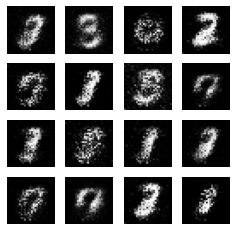

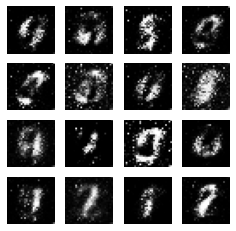

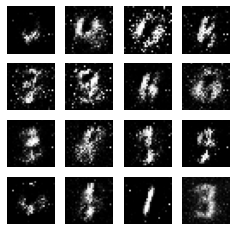

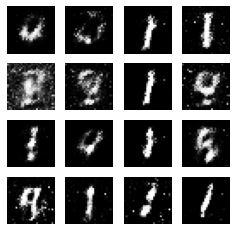

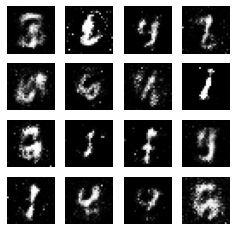

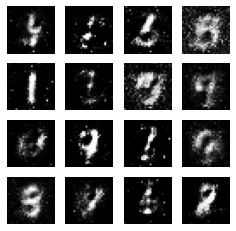

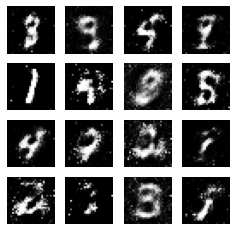

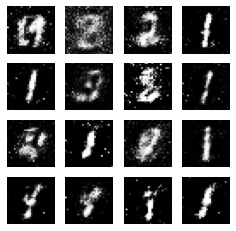

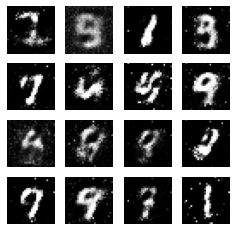

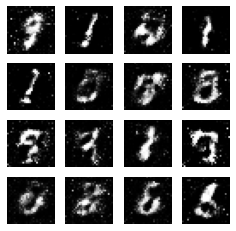

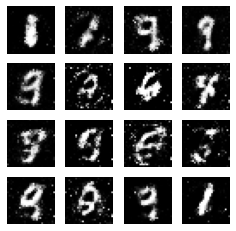

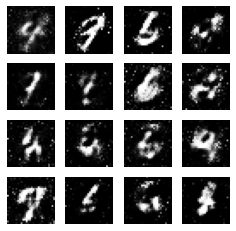

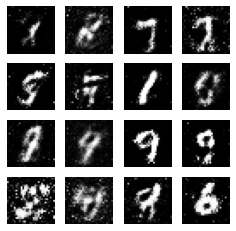

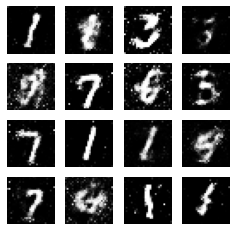

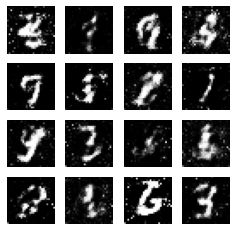

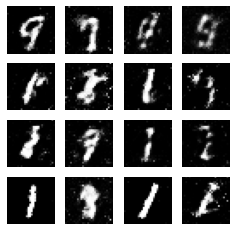

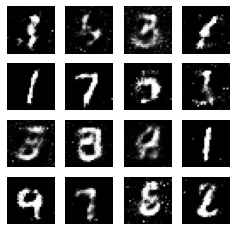

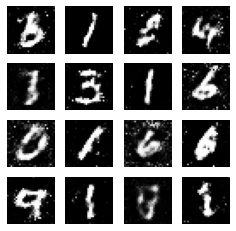

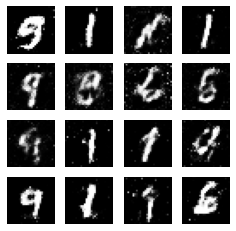

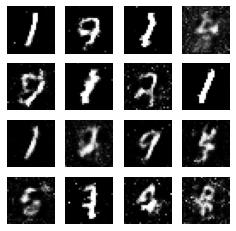

In [30]:
iterations = 20000 # 하이퍼파라미터 설정
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval) # 지정된 횟수 동안 GAN 훈련